In [28]:
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    AutoConfig,
    Trainer,
    TrainingArguments,
    DataCollatorWithPadding
)
from sklearn.metrics import accuracy_score, precision_recall_fscore_support,confusion_matrix,classification_report
from collections import defaultdict
import matplotlib.pyplot as plt
from transformers import EarlyStoppingCallback


In [2]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [3]:
# Configuration
DATA_PATH = "/content/drive/MyDrive/nepali-sentiment-analysis"
MODEL_NAME = "NepBERTa/NepBERTa"
NUM_LABELS = 3
EPOCHS = 10
BATCH_SIZE = 16

In [4]:
# Load dataset
def load_data():
    test_data = pd.read_csv(f"{DATA_PATH}/test.csv")
    train_data = pd.read_csv(f"{DATA_PATH}/train.csv")

    return train_data, test_data

train_data, test_data = load_data()

In [5]:
train_data.head()

,Title,Sentiment
0,‘वार टु’ मा रजाटोसको इन्ट्री,neutral
1,तस्बिरमा नेपाल र वेस्ट इन्डिज ‘ए’ बीचको खेल,neutral
2,बिमा प्राधिकरणका अध्यक्ष सिलवालविरुद्ध भ्रष्टा...,negative
3,शशांकको सनसनी,neutral
4,सन् १९७० मा आजकै दिन : जोन वेनलाई ओस्कार,positive


In [6]:
test_data.head()

,Title,Sentiment
0,माधव नेपालको राजनीतिक प्रतिवेदनमा सरकारको स्थि...,negative
1,तिलोत्तमामा अन्तर्राष्ट्रिय क्रिकेट मैदान,positive
2,अझै तीन दिन पानी पर्ने पूर्वानुमान,neutral
3,जुम्ला रारा म्याराथनले हजारौं 'हरिबहादुरहरु' ज...,positive
4,स्वीकृति नलिएका १५ पदाधिकारीलाई बेलायत जान रोकिने,negative


In [7]:
# Map sentiment labels to integers
LABEL_MAP = {'negative': 0, 'neutral': 1, 'positive': 2}
train_data['labels'] = train_data['Sentiment'].map(LABEL_MAP)
test_data['labels'] = test_data['Sentiment'].map(LABEL_MAP)

In [8]:
print("Train dataset size:", len(train_data))
print("Test dataset size:", len(test_data))

Train dataset size: 3500
Test dataset size: 1500


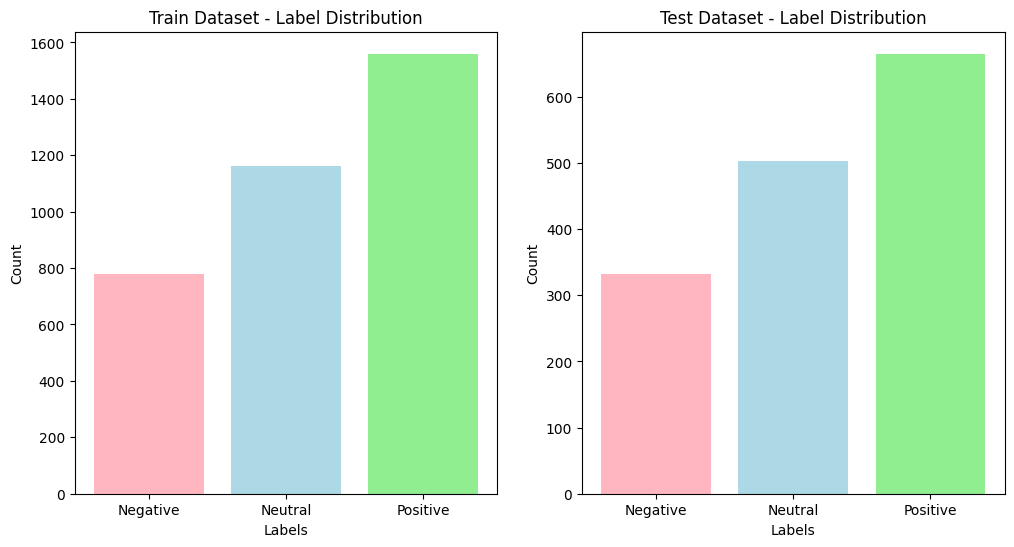

In [9]:
# Visualizing data distribution
def plot_label_distribution():
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))
    for i, (dataset, title) in enumerate(zip([train_data, test_data], ['Train', 'Test'])):
        labels = dataset['labels'].value_counts().sort_index()
        axs[i].bar(labels.index, labels.values, color=['#ffb6c1', '#add8e6', '#90ee90'])
        axs[i].set_xlabel('Labels')
        axs[i].set_ylabel('Count')
        axs[i].set_title(f'{title} Dataset - Label Distribution')
        axs[i].set_xticks(labels.index)
        axs[i].set_xticklabels(['Negative', 'Neutral', 'Positive'])
    plt.show()

plot_label_distribution()

In [10]:
# Load tokenizer and model
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

config.json:   0%|          | 0.00/652 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/547k [00:00<?, ?B/s]

In [11]:
max_length_train = train_data['Title'].apply(lambda x: len(tokenizer(str(x), truncation=False)["input_ids"])).max()
max_length_test = test_data['Title'].apply(lambda x: len(tokenizer(str(x), truncation=False)["input_ids"])).max()
max_length = max(max_length_train, max_length_test)

print("Maximum sequence length:", max_length)


Maximum sequence length: 47


In [12]:
# Tokenize datasets
def tokenize_data(texts):
    return tokenizer(texts, truncation=True, padding=True, max_length=max_length)

train_encodings = tokenize_data(train_data['Title'].tolist())
test_encodings = tokenize_data(test_data['Title'].tolist())

In [13]:
# Create PyTorch datasets
class SentimentDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item["labels"] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = SentimentDataset(train_encodings, train_data['labels'].tolist())
test_dataset = SentimentDataset(test_encodings, test_data['labels'].tolist())

In [14]:
# Configure model
config = AutoConfig.from_pretrained(MODEL_NAME, num_labels=NUM_LABELS)
# if cuda is available use cuda otherwise use cpu
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, config=config, from_tf=True).to(device)

tf_model.h5:   0%|          | 0.00/534M [00:00<?, ?B/s]

All TF 2.0 model weights were used when initializing BertForSequenceClassification.

All the weights of BertForSequenceClassification were initialized from the TF 2.0 model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use BertForSequenceClassification for predictions without further training.


In [15]:
# Data collator for batching and padding
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [16]:
# Define evaluation metrics
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average='weighted')
    acc = accuracy_score(labels, predictions)
    return {"accuracy": acc, "f1": f1, "precision": precision, "recall": recall}

In [17]:
# Training arguments
training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    num_train_epochs=EPOCHS,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=10,
    save_total_limit=2,
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="accuracy"
)

In [18]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    processing_class=tokenizer,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]  # Add early stopping
)

In [19]:
# Train the model
trainer.train()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: riyaacharya78 (riyaacharya78-kathandu-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.831300,0.754167,0.666000,0.663105,0.670574,0.666000
2,0.626800,0.753010,0.690667,0.683293,0.686478,0.690667
3,0.464800,0.798973,0.692667,0.696604,0.715757,0.692667
4,0.360300,0.872291,0.703333,0.701299,0.700615,0.703333
5,0.306100,0.988559,0.702000,0.700837,0.701931,0.702000
6,0.290800,1.059749,0.700667,0.700654,0.700642,0.700667
7,0.262300,1.102198,0.710667,0.711500,0.713750,0.710667
8,0.213200,1.211420,0.702000,0.698872,0.699185,0.702000
9,0.163900,1.227412,0.714000,0.712552,0.712315,0.714000
10,0.156000,1.259715,0.707333,0.707650,0.708102,0.707333


TrainOutput(global_step=2190, training_loss=0.3674237423835824, metrics={'train_runtime': 577.4839, 'train_samples_per_second': 60.608, 'train_steps_per_second': 3.792, 'total_flos': 845354633130000.0, 'train_loss': 0.3674237423835824, 'epoch': 10.0})

In [20]:
# Evaluate on the test dataset
results = trainer.evaluate(test_dataset)
print("Evaluation Results:", results)

Evaluation Results: {'eval_loss': 1.2274121046066284, 'eval_accuracy': 0.714, 'eval_f1': 0.7125523534978577, 'eval_precision': 0.7123150622917572, 'eval_recall': 0.714, 'eval_runtime': 4.1505, 'eval_samples_per_second': 361.399, 'eval_steps_per_second': 22.648, 'epoch': 10.0}


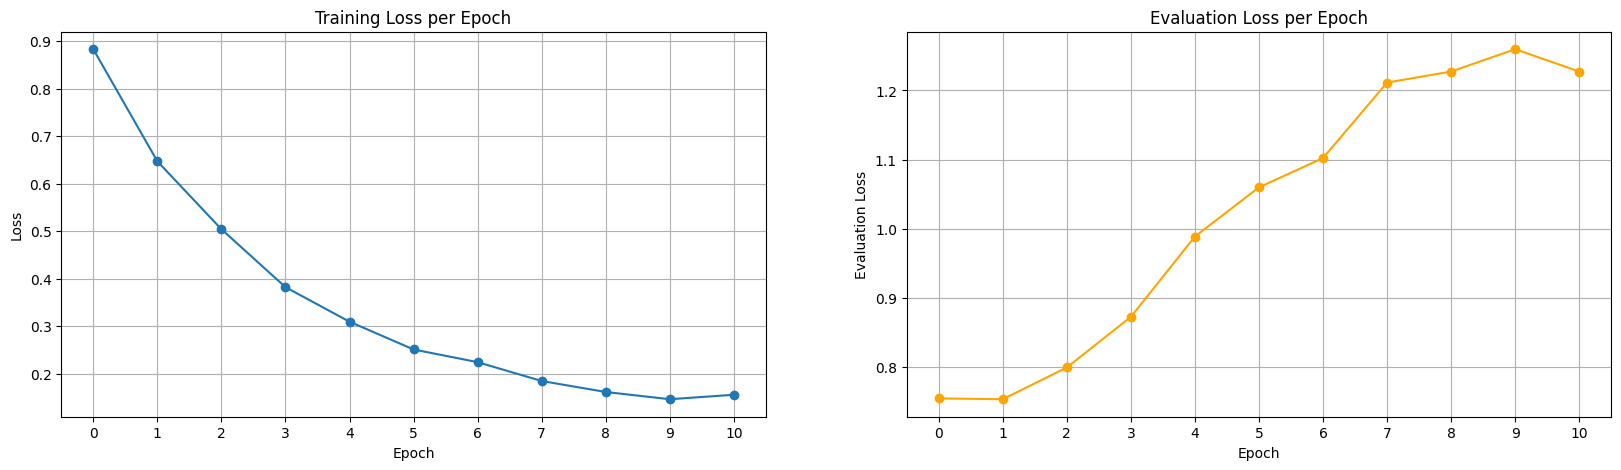

In [21]:
# Grouping losses by epoch
epoch_losses = defaultdict(list)
eval_losses = []  # Initialize eval_losses as an empty list

# Collecting losses
for log in trainer.state.log_history:
    if 'loss' in log and 'epoch' in log:
        epoch = int(log['epoch'])  # Convert to integer to group logs within the same epoch
        epoch_losses[epoch].append(log['loss'])
    if 'eval_loss' in log:
        eval_losses.append(log['eval_loss']) # Append eval_loss to the list


# Calculating average loss per epoch
epochs = sorted(epoch_losses.keys())
avg_losses = [sum(losses) / len(losses) for losses in [epoch_losses[epoch] for epoch in epochs]]

# Create subplots with 1 row and 2 columns
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 5))  # Adjust figsize as needed

# Plot training loss on the first subplot (ax1)
ax1.plot(epochs, avg_losses, marker='o')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Training Loss per Epoch')
ax1.set_xticks(epochs)
ax1.grid()

# Plot evaluation loss on the second subplot (ax2)
ax2.plot(epochs, eval_losses, marker='o', color='orange')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Evaluation Loss')
ax2.set_title('Evaluation Loss per Epoch')
ax2.set_xticks(epochs)
ax2.grid()

# Display the plots
plt.show()

In [24]:
predictions = trainer.predict(test_dataset)
y_pred = np.argmax(predictions.predictions, axis=1)
y_true = test_dataset.labels


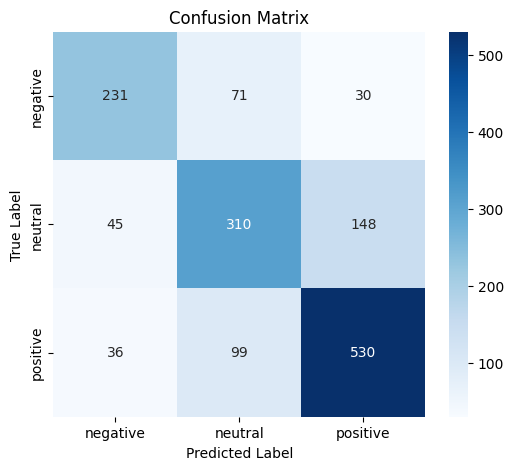

In [26]:
# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=LABEL_MAP.keys(), yticklabels=LABEL_MAP.keys())
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


In [30]:
predictions = trainer.predict(test_dataset)
y_pred = np.argmax(predictions.predictions, axis=1)
y_true = test_dataset.labels

class_names = list(LABEL_MAP.keys())

# Convert y_true and y_pred to lists if they are not already
y_true_list = y_true
y_pred_list = y_pred.tolist()

print(classification_report(y_true_list, y_pred_list, target_names=class_names))

              precision    recall  f1-score   support

    negative       0.74      0.70      0.72       332
     neutral       0.65      0.62      0.63       503
    positive       0.75      0.80      0.77       665

    accuracy                           0.71      1500
   macro avg       0.71      0.70      0.71      1500
weighted avg       0.71      0.71      0.71      1500



In [31]:
def get_prediction(text):
    # Tokenize input text
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True)
    inputs = {key: value.to(model.device) for key, value in inputs.items()}

    # Get model predictions
    with torch.no_grad():
        outputs = model(**inputs)

    # Convert logits to probabilities
    probabilities = torch.nn.functional.softmax(outputs.logits, dim=-1)

    # Get predicted label and confidence score
    predicted_label = torch.argmax(probabilities, dim=-1).item()
    confidence_score = probabilities[0, predicted_label].item()

    # Map predicted label back to sentiment
    label_name = {v: k for k, v in LABEL_MAP.items()}[predicted_label]

    return label_name, confidence_score


In [35]:
text = "कांग्रेस संसदीय दलको बैठक बस्दै"
prediction = get_prediction(text)
print(prediction)

('neutral', 0.9929921627044678)


In [34]:
text = 'भूमि व्यवस्था तथा अभिलेख विभागका महानिर्देशकमाथि कार्यकक्षमै दुर्व्यवहार'
prediction = get_prediction(text)
print(prediction)

('negative', 0.9968294501304626)


In [36]:
text = 'नेपालमा लगानीको अध्ययन संयन्त्र बनाउन कतार तयार'
prediction = get_prediction(text)
print(prediction)

('positive', 0.9962418079376221)
